In [2]:
from dotenv import load_dotenv
_ = load_dotenv("../.env")

In [72]:
import sys
sys.path.append("..")

In [193]:
from langchain_ollama import ChatOllama
from langchain_anthropic import ChatAnthropic

local_llm = "qwen2.5:latest"
llm = ChatOllama(model=local_llm, temperature=0)
# llm = ChatOllama(model="qwen2.5:7b", temperature=0)
# llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

### VectorDB

In [194]:
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_chroma import Chroma

In [195]:
embedder = OllamaEmbeddings(model="nomic-embed-text")
db = Chroma(
        persist_directory="chroma_db", 
        embedding_function=embedder
)

### Router

In [196]:
import json
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or tool call.
The vectorstore contains details about datasets from World Resource Institute(WRI).
Use the vectorstore for questions on topics related to searching datasets. 
For specific question on forest fires use the tool call.
Return JSON with single key, route, that is 'vectorstore' or 'glad-tool' depending on the question."""

queries = ["I am interested in biodiversity conservation in Argentina", 
           "I would like to explore helping with forest loss in Amazon",
           "show datasets related to mangrooves",
           "find forest fires in milan for the year 2022",
           "show stats on forest fires over Ihorombe for 2021"
          ]

In [197]:
# tests
for query in queries:
    response = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [
            HumanMessage(
                content=query
            )
        ]
    )
    response = json.loads(response.content)
    print(query, " ---> ", response["route"])

I am interested in biodiversity conservation in Argentina  --->  vectorstore
I would like to explore helping with forest loss in Amazon  --->  glad-tool
show datasets related to mangrooves  --->  vectorstore
find forest fires in milan for the year 2022  --->  glad-tool
show stats on forest fires over Ihorombe for 2021  --->  glad-tool


### RAG

In [198]:
rag_prompt = """You are a World Resources Institute (WRI) assistant specializing in dataset recommendations.

Instructions:
1. Use the following context to inform your response:
{context}

2. User Question:
{question}

3. Response Format:
   - Only use information from the provided context
   - For each recommended dataset:
     - Dataset URL
     - Two-line explanation of why this dataset is relevant to the user's problem
"""

In [199]:
retriver = db.as_retriever(k=4)

In [200]:
question = "I am interested in biodiversity conservation in Argentina"
docs = retriver.invoke(question)

In [201]:
def make_context(docs):
    fmt_docs = []
    for doc in docs:
        url = f"https://data-api.globalforestwatch.org/dataset/{doc.metadata['dataset']}"
        content = "URL: " + url + "\n" + doc.page_content
        fmt_docs.append(content)
    return "\n\n".join(fmt_docs)

In [202]:
docs_txt = make_context(docs)

In [203]:
rag_prompt_fmt = rag_prompt.format(context=docs_txt, question=question)

In [204]:
generation = llm.invoke([HumanMessage(content=rag_prompt_fmt)])

In [205]:
print(generation.content)

- **Dataset URL:** https://data-api.globalforestwatch.org/dataset/arg_otbn_forest_loss  
  **Explanation:** This dataset provides insights into deforestation in Argentinean native forests from 2007-2022, which is crucial for understanding the impact on biodiversity and guiding conservation efforts.

- **Dataset URL:** https://data-api.globalforestwatch.org/dataset/birdlife_key_biodiversity_areas  
  **Explanation:** Key Biodiversity Areas (KBAs) in Argentina highlight critical sites for conservation, offering essential information to protect species with limited ranges and habitats.


# Agent

In [264]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated
from IPython.display import Image, display, Markdown
from langgraph.graph import START, MessagesState, StateGraph, END, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AnyMessage, ToolMessage

from src.tools.glad.weekly_alerts_tool import glad_weekly_alerts_tool
from src.tools.location.tool import location_tool

In [229]:
tools = [location_tool, glad_weekly_alerts_tool]
llm_with_tools = llm.bind_tools(tools)

In [240]:
class GraphState(MessagesState):
    question: str  # User question
    generation: str  # LLM generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

### Nodes

In [256]:
def retrieve(state):
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriver.invoke(question)
    return {"documents": documents}

def generate(state):
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = make_context(documents)
    rag_prompt_fmt = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_fmt)])
    return {"generation": generation, "loop_step": loop_step + 1}

def assistant(state):
    sys_msg = SystemMessage(content="""You are a helpful assistant tasked with answering the user queries for WRI data API.
        Use the `location-tool` to get iso, adm1 & adm2 of any region or place.
        Use the `glad-weekly-alerts-tool` to get forest fire information for a particular year. Think through the solution step-by-step first and then execute.
        
        For eg: If the query is "Find forest fires in Milan for the year 2024"
        Steps
        1. Use the `location_tool` to get iso, adm1, adm2 for place `Milan` by passing `query=Milan`
        2. Pass iso, adm1, adm2 along with year `2024` as args to `glad-weekly-alerts-tool` to get information about forest fire alerts.
        """)
    return {"messages": [llm_with_tools.invoke([sys_msg] + [HumanMessage(state["question"])])]}

# tool_node = ToolNode(tools)

In [257]:
tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: dict):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        print(tool)
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

### Edges

In [258]:
def router(state):
    print("---ROUTER---")
    response = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [
            HumanMessage(
                content=state["question"]
            )
        ]
    )
    route = json.loads(response.content)["route"]
    if route == "vectorstore":
        print("---ROUTING-TO-RAG---")
        return "retrieve"
    elif route == "glad-tool":
        print("---ROUTING-TO-TOOLS---")
        return "assistant"

### Graph

In [259]:
from IPython.core.debugger import set_trace

In [260]:
def call_tool(state):
    # set_trace()
    last_msg = state["messages"][-1]
    if not last_msg.tool_calls:
        return "__end__"
    return "tools"

In [261]:
wf = StateGraph(GraphState)

wf.add_node("retrieve", retrieve)
wf.add_node("generate", generate)
wf.add_node("assistant", assistant)
wf.add_node("tools", tool_node)

wf.set_conditional_entry_point(
    router,
    {
        "retrieve": "retrieve",
        "assistant": "assistant"
    }
)
wf.add_edge("retrieve", "generate")
wf.add_edge("generate", END)
wf.add_conditional_edges(
    "assistant",
    call_tool
)
wf.add_edge("tools", "assistant")
wf.add_edge("assistant", END)

graph = wf.compile()

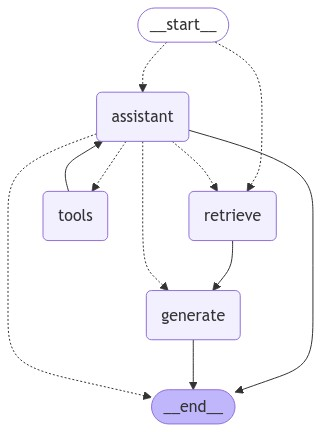

In [262]:
display(Image(graph.get_graph(xray=False).draw_mermaid_png()))

In [265]:
graph.invoke({"question": "show stats on forest fires over Ihorombe for 2021"})

---ROUTER---
---ROUTING-TO-TOOLS---
name='location-tool' description='Find locations and their administrative hierarchies given a place name.\n      Returns matches at different administrative levels (ADM2, ADM1, ISO) with their IDs and names.\n\n    Args:\n        query (str): Location name to search for\n        threshold (int, optional): Minimum similarity score. Defaults to 70.\n\n    Returns:\n        dict: matching locations' args_schema=<class 'src.tools.location.tool.LocationInput'> func=<function location_tool at 0x770dd84b3420>
name='location-tool' description='Find locations and their administrative hierarchies given a place name.\n      Returns matches at different administrative levels (ADM2, ADM1, ISO) with their IDs and names.\n\n    Args:\n        query (str): Location name to search for\n        threshold (int, optional): Minimum similarity score. Defaults to 70.\n\n    Returns:\n        dict: matching locations' args_schema=<class 'src.tools.location.tool.LocationInpu

KeyboardInterrupt: 

In [248]:
result = graph.invoke({"question": "I am interested in biodiversity conservation in Argentina"})

---ROUTER---
---ROUTING-TO-RAG---
---RETRIEVE---
---GENERATE---


In [249]:
Markdown(result["generation"].content)

- **Dataset URL:** https://data-api.globalforestwatch.org/dataset/arg_otbn_forest_loss  
  **Explanation:** This dataset provides insights into deforestation in Argentinean native forests from 2007-2022, which is crucial for understanding the impact on biodiversity and guiding conservation efforts.

- **Dataset URL:** https://data-api.globalforestwatch.org/dataset/birdlife_key_biodiversity_areas  
  **Explanation:** Key Biodiversity Areas (KBAs) in Argentina highlight critical sites for conservation, offering essential information to protect species with limited ranges and habitats.